In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download sripaadsrinivasan/audio-mnist

Dataset URL: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist
License(s): CC0-1.0
 99% 942M/948M [00:11<00:00, 62.6MB/s]
100% 948M/948M [00:11<00:00, 89.7MB/s]


In [4]:
! unzip /content/audio-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/51/0_51_1.wav      
  inflating: data/51/0_51_10.wav     
  inflating: data/51/0_51_11.wav     
  inflating: data/51/0_51_12.wav     
  inflating: data/51/0_51_13.wav     
  inflating: data/51/0_51_14.wav     
  inflating: data/51/0_51_15.wav     
  inflating: data/51/0_51_16.wav     
  inflating: data/51/0_51_17.wav     
  inflating: data/51/0_51_18.wav     
  inflating: data/51/0_51_19.wav     
  inflating: data/51/0_51_2.wav      
  inflating: data/51/0_51_20.wav     
  inflating: data/51/0_51_21.wav     
  inflating: data/51/0_51_22.wav     
  inflating: data/51/0_51_23.wav     
  inflating: data/51/0_51_24.wav     
  inflating: data/51/0_51_25.wav     
  inflating: data/51/0_51_26.wav     
  inflating: data/51/0_51_27.wav     
  inflating: data/51/0_51_28.wav     
  inflating: data/51/0_51_29.wav     
  inflating: data/51/0_51_3.wav      
  inflating: data/51/0_51_30.wav     
  inflating: data/51/0_51_31.wav     

In [5]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress indication

# Path to the dataset
dataset_path = '/content/data'

# Load dataset
def load_audio_files(dataset_path):
    X = []
    y = []
    for folder in tqdm(os.listdir(dataset_path), desc='Loading dataset'):  # Add tqdm here
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):  # Check if it's a directory
            continue
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path, sr=16000)
                X.append(audio)
                label = int(file.split('_')[0])
                y.append(label)
    return X, y

# Load the dataset
X, y = load_audio_files(dataset_path)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Loading dataset: 100%|██████████| 61/61 [00:48<00:00,  1.27it/s]

Training set size: 24000
Test set size: 6000


In [6]:
def extract_mfcc_features(audio, sr, n_mfcc=12, frame_length=0.025, hop_length=0.01):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=int(frame_length*sr), n_mels=24)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
    return combined.flatten()

# Extract MFCC features for the dataset
X_train_mfcc = [extract_mfcc_features(x, 16000) for x in X_train]
X_test_mfcc = [extract_mfcc_features(x, 16000) for x in X_test]

# Padding the MFCC features to have the same length
def pad_sequences(sequences, maxlen):
    return np.array([np.pad(seq, (0, maxlen - len(seq)), mode='constant') if len(seq) < maxlen else seq[:maxlen] for seq in sequences])

maxlen = max(max(len(x) for x in X_train_mfcc), max(len(x) for x in X_test_mfcc))
X_train_mfcc = pad_sequences(X_train_mfcc, maxlen)
X_test_mfcc = pad_sequences(X_test_mfcc, maxlen)

# Convert to numpy arrays
X_train_mfcc = np.array(X_train_mfcc)
X_test_mfcc = np.array(X_test_mfcc)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("MFCC feature extraction complete.")


MFCC feature extraction complete.


In [7]:
X_train_mfcc.shape

(24000, 1152)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# MLP class
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Weights initialization
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size) * 0.01

        # Bias initialization
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.bias_output = np.zeros((1, self.output_size))

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output_output = relu(self.output_input)

        return self.output_output

    def backward(self, X, y, output):
        output_error = y - output
        output_delta = output_error * relu_derivative(self.output_input)

        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * relu_derivative(self.hidden_input)

        self.weights_hidden_output += self.learning_rate * np.dot(self.hidden_output.T, output_delta)
        self.weights_input_hidden += self.learning_rate * np.dot(X.T, hidden_delta)

        self.bias_output += self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        self.bias_hidden += self.learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

    def train(self, X, y, epochs=30):
        mse_errors = []
        accuracies = []

        for epoch in range(epochs):
            total_error = 0
            correct_predictions = 0
            class_correct = np.zeros(self.output_size)
            class_total = np.zeros(self.output_size)

            for i in range(len(X)):
                X_sample = X[i].reshape(1, -1)
                y_sample = y[i].reshape(1, -1)

                output = self.forward(X_sample)

                self.backward(X_sample, y_sample, output)

                # Calculate accuracy
                predicted_class = np.argmax(output)
                true_class = np.argmax(y_sample)
                if predicted_class == true_class:
                    correct_predictions += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1

                total_error += mse(y_sample, output)

            avg_error = total_error / len(X)
            accuracy = correct_predictions / len(X)
            mse_errors.append(avg_error)
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}/{epochs}, Avg Error: {avg_error:.6f}, Accuracy: {accuracy:.6f}")

            # Print accuracy for each class
            for i in range(self.output_size):
                class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                print(f"Class {i} Accuracy: {class_accuracy:.6f}")

        return mse_errors, accuracies

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

# Define the size of the input, hidden and output layers
input_size = X_train_mfcc.shape[1]
hidden_size = (input_size + 10) // 2
output_size = 10

# Initialize the MLP
mlp = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.001)

# One-hot encoding
def to_one_hot(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train_one_hot = to_one_hot(y_train, output_size)

# Train the MLP
mse_errors, accuracies = mlp.train(X_train_mfcc, y_train_one_hot, epochs=5)


Epoch 1/5, Avg Error: 0.030532, Accuracy: 0.859375
Class 0 Accuracy: 0.857022
Class 1 Accuracy: 0.861970
Class 2 Accuracy: 0.830743
Class 3 Accuracy: 0.832843
Class 4 Accuracy: 0.900621
Class 5 Accuracy: 0.844555
Class 6 Accuracy: 0.916913
Class 7 Accuracy: 0.837905
Class 8 Accuracy: 0.912360
Class 9 Accuracy: 0.799009
Epoch 2/5, Avg Error: 0.012752, Accuracy: 0.954417
Class 0 Accuracy: 0.961620
Class 1 Accuracy: 0.955913
Class 2 Accuracy: 0.950021
Class 3 Accuracy: 0.947921
Class 4 Accuracy: 0.969358
Class 5 Accuracy: 0.957606
Class 6 Accuracy: 0.969211
Class 7 Accuracy: 0.934746
Class 8 Accuracy: 0.966928
Class 9 Accuracy: 0.931077
Epoch 3/5, Avg Error: 0.009742, Accuracy: 0.967917
Class 0 Accuracy: 0.974694
Class 1 Accuracy: 0.976102
Class 2 Accuracy: 0.967241
Class 3 Accuracy: 0.960941
Class 4 Accuracy: 0.978468
Class 5 Accuracy: 0.973400
Class 6 Accuracy: 0.980177
Class 7 Accuracy: 0.942228
Class 8 Accuracy: 0.975196
Class 9 Accuracy: 0.950887
Epoch 4/5, Avg Error: 0.008012, Accur

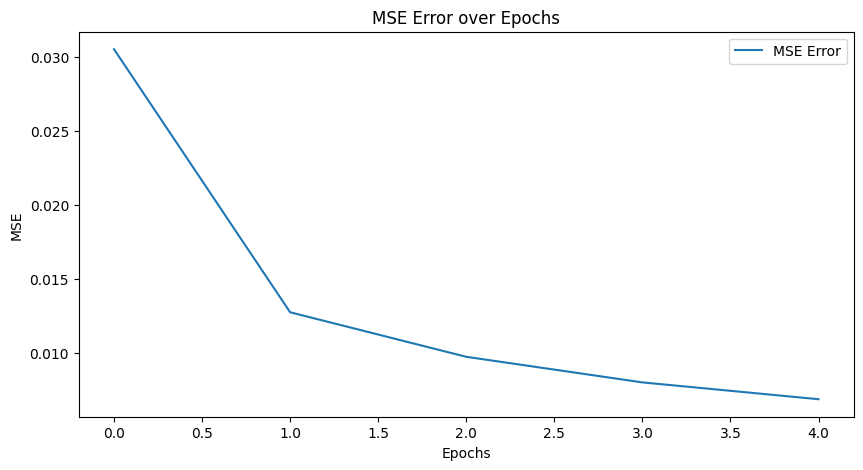

In [21]:

# Plot MSE errors
plt.figure(figsize=(10, 5))
plt.plot(mse_errors, label='MSE Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE Error over Epochs')
plt.legend()
plt.show()






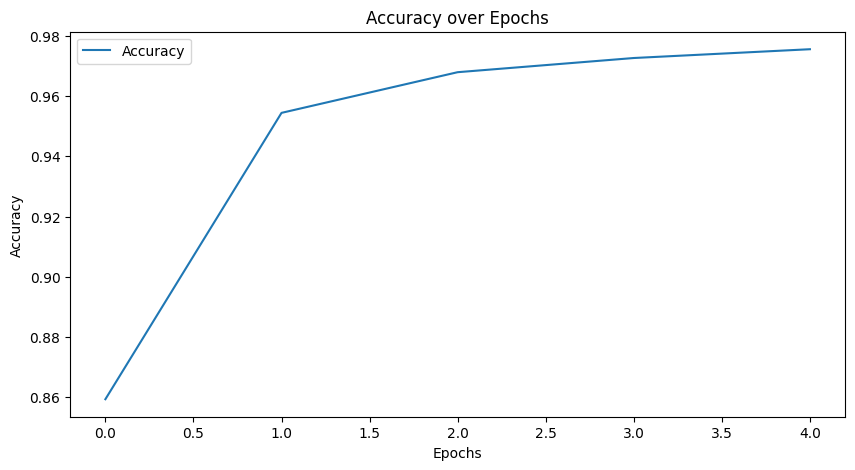

In [22]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [23]:
# Predict on test data
y_pred = mlp.predict(X_test_mfcc)

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate accuracy for each class on test data
class_correct = np.zeros(output_size)
class_total = np.zeros(output_size)

for i in range(len(y_test)):
    true_class = y_test[i]
    predicted_class = y_pred[i]
    if true_class == predicted_class:
        class_correct[true_class] += 1
    class_total[true_class] += 1

for i in range(output_size):
    class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Test Class {i} Accuracy: {class_accuracy * 100:.2f}%")

Test Accuracy: 96.12%
Test Class 0 Accuracy: 97.14%
Test Class 1 Accuracy: 97.38%
Test Class 2 Accuracy: 95.96%
Test Class 3 Accuracy: 96.45%
Test Class 4 Accuracy: 98.63%
Test Class 5 Accuracy: 97.14%
Test Class 6 Accuracy: 95.71%
Test Class 7 Accuracy: 92.09%
Test Class 8 Accuracy: 97.42%
Test Class 9 Accuracy: 93.24%
